In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter

In [45]:
def reduce_noise_with_median_filter(image_path, filter_size=3):
    """
    Applique un filtre médian pour réduire le bruit de l'image.
    
    Parameters:
    - image_path: Chemin vers l'image à traiter.
    - filter_size: Taille du filtre médian (doit être un entier impair, par défaut 3).
    
    Returns:
    - Image: L'image avec la réduction de bruit appliquée.
    """
    # Ouvrir l'image et la convertir en tableau numpy
    image = Image.open(image_path)
    image_array = np.array(image)
    
    if filter_size % 2 == 0:
        raise ValueError("La taille du filtre doit être un entier impair.")
    
    padded_image = np.pad(image_array, pad_width=filter_size // 2, mode='edge')
    filtered_image = np.zeros_like(image_array)
    
    # Appliquer le filtre médian à chaque pixel de l'image
    rows, cols = image_array.shape[:2]
    for i in range(rows):
        for j in range(cols):
            # Extraire le voisinage autour du pixel courant
            neighborhood = padded_image[i:i + filter_size, j:j + filter_size]
            if image_array.ndim == 3:  # Si l'image est RGB
                for k in range(3):  # Appliquer le filtre à chaque canal
                    filtered_image[i, j, k] = np.median(neighborhood[:, :, k])
            else:  # Si l'image est en niveaux de gris
                filtered_image[i, j] = np.median(neighborhood)
    
    # Retourner l'image filtrée sous forme d'objet PIL
    return Image.fromarray(filtered_image)

image.filter(ImageFilter.MidFilter(3))

In [46]:
def enhance_brightness(image_path, target_brightness=130):
    """
    Améliore la luminosité de l'image en ajustant les valeurs des pixels
    pour atteindre une luminosité moyenne cible.
    
    Parameters:
    image_path (str): Chemin de l'image d'entrée.
    target_brightness (float): La luminosité cible que l'on souhaite atteindre (par défaut 130).
    
    Returns:
    Image: L'image avec la luminosité améliorée.
    """
    # Ouvrir l'image et la convertir en mode RGB
    with Image.open(image_path) as image:
        image = image.convert('RGB')
        
        # Convertir l'image en tableau numpy
        img_array = np.array(image)
        
        # Calculer la luminance moyenne (somme pondérée des valeurs RGB)
        luminance = 0.2989 * img_array[:, :, 0] + 0.5870 * img_array[:, :, 1] + 0.1140 * img_array[:, :, 2]
        average_brightness = np.mean(luminance)
        
        # Calculer le facteur de luminosité pour atteindre la luminosité cible
        brightness_factor = target_brightness / average_brightness
        
        # Ajuster la luminosité en multipliant chaque pixel par le facteur
        enhanced_pixels = [
            (
                int(min(255, pixel[0] * brightness_factor)),
                int(min(255, pixel[1] * brightness_factor)),
                int(min(255, pixel[2] * brightness_factor))
            )
            for pixel in list(image.getdata())
        ]
        
        # Créer une nouvelle image avec les pixels ajustés
        enhanced_image = Image.new(image.mode, image.size)
        enhanced_image.putdata(enhanced_pixels)
        
        return enhanced_image

In [47]:
def enhance_image_dynamics(image_path):
    """
    Applique un étirement de l'histogramme pour améliorer la dynamique de l'image.
    """
    # Charger l'image
    image = Image.open(image_path)
    image_array = np.array(image)

    # Fonction pour étirer l'histogramme d'un canal
    def stretch_histogram(channel):
        min_val = np.min(channel)
        max_val = np.max(channel)
        # Étirer les valeurs pour occuper toute la plage de 0 à 255
        stretched = (channel - min_val) * (255 / (max_val - min_val))
        return stretched.astype(np.uint8)

    # Appliquer l'étirement de l'histogramme à chaque canal
    r, g, b = image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]
    r_stretched = stretch_histogram(r)
    g_stretched = stretch_histogram(g)
    b_stretched = stretch_histogram(b)

    # Reconstituer l'image avec les canaux étirés
    enhanced_image_array = np.stack((r_stretched, g_stretched, b_stretched), axis=-1)
    enhanced_image = Image.fromarray(enhanced_image_array)

    return enhanced_image

In [48]:
def troncature_image(image_path, low_percentile=2, high_percentile=98):
    """Applique une troncature à l'image en utilisant les percentiles donnés."""
    # Charger l'image
    image = Image.open(image_path)
    image_array = np.array(image)
    
    # Fonction pour appliquer la troncature à un canal
    def clip_histogram(channel, low_perc, high_perc):
        # Calcul des valeurs de troncature à partir des percentiles
        low_val = np.percentile(channel, low_perc)
        high_val = np.percentile(channel, high_perc)
        
        # Appliquer la troncature
        clipped = np.clip(channel, low_val, high_val)
        
        # Étendre les valeurs tronquées pour occuper toute la plage de 0 à 255
        stretched = 255 * (clipped - low_val) / (high_val - low_val)
        return stretched.astype(np.uint8)
    
    # Appliquer la troncature et l'étirement à chaque canal de couleur (R, G, B)
    r, g, b = image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]
    r_clipped = clip_histogram(r, low_percentile, high_percentile)
    g_clipped = clip_histogram(g, low_percentile, high_percentile)
    b_clipped = clip_histogram(b, low_percentile, high_percentile)
    
    # Reconstituer l'image avec les canaux tronqués et étirés
    enhanced_image_array = np.stack((r_clipped, g_clipped, b_clipped), axis=-1)
    enhanced_image = Image.fromarray(enhanced_image_array)
    
    return enhanced_image

In [49]:
def ameliorer_contraste(image, factor=2):
    """
    Améliore le contraste de l'image en utilisant l'égalisation d'histogramme et un facteur de contraste.
    """
    # Convertir l'image en tableau numpy
    img_array = np.array(image)
    
    # Calculer l'histogramme de l'image
    histogram, bins = np.histogram(img_array.flatten(), bins=256, range=[0, 256])
    
    # Calculer la distribution cumulative
    cdf = histogram.cumsum()
    cdf_normalized = cdf * histogram.max() / cdf.max()  # Normaliser la CDF
    
    # Utiliser l'interpolation linéaire de la CDF pour trouver les nouveaux niveaux de gris
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0)
    
    # Mapper les pixels de l'image d'origine aux niveaux de gris égalisés
    img_equalized = cdf[img_array]
    equalized_image = Image.fromarray(img_equalized.astype(np.uint8))
    
    # Ajuster le contraste avec le facteur spécifié
    enhancer = ImageEnhance.Contrast(equalized_image)
    contrasted_image = enhancer.enhance(factor)
    
    return contrasted_image

In [50]:
def ameliorer_saturation(image):
    """Améliore la saturation de l'image en égalisant l'histogramme du canal de saturation."""
    # Convertir l'image en mode HSV
    hsv_image = image.convert('HSV')
    hsv_array = np.array(hsv_image)
    
    # Extraire les canaux H, S, et V
    h, s, v = hsv_array[:, :, 0], hsv_array[:, :, 1], hsv_array[:, :, 2]
    
    # Améliorer la saturation en égalisant l'histogramme
    s_equalized = equalize_histogram(s)
    
    # Reconstruire l'image HSV avec la saturation améliorée
    hsv_equalized = np.stack((h, s_equalized, v), axis=-1)
    enhanced_hsv_image = Image.fromarray(hsv_equalized, 'HSV')
    
    # Convertir l'image de retour en mode RGB
    enhanced_image = enhanced_hsv_image.convert('RGB')
    return enhanced_image

In [51]:
def equalize_histogram(channel):
    """Égalise l'histogramme d'un canal de l'image."""
    # Calculer l'histogramme
    hist, bins = np.histogram(channel.flatten(), 256, [0, 256])
    
    # Calculer la distribution cumulative (CDF)
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    
    # Utiliser l'interpolation linéaire de la CDF pour obtenir les nouvelles valeurs
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')
    
    # Appliquer la transformation au canal
    channel_equalized = cdf[channel]
    
    return channel_equalized

In [52]:
def charger_image(image_path):
    """Charge une image et la convertit en niveaux de gris."""
    image = Image.open(image_path)
    grayscale_image = image.convert('L')
    return grayscale_image

In [ ]:
def calculer_statistiques(img_array):
    """Calcule les statistiques de l'image en niveaux de gris."""
    luminosite_moyenne = np.mean(img_array)
    ecart_type = np.std(img_array)
    min_val = np.min(img_array)
    max_val = np.max(img_array)
    return luminosite_moyenne, ecart_type, min_val, max_val

In [54]:
def determiner_besoins_pretraitement(luminosite_moyenne, ecart_type, min_val, max_val, saturation_moyenne):
    """Détermine les besoins en prétraitement de l'image, y compris la troncature."""
    contraste_necessaire = ecart_type < 50
    luminosite_necessaire = luminosite_moyenne < 100
    bruit_necessaire = ecart_type > 80
    dynamique_necessaire = (max_val - min_val) < 100
    saturation_necessaire = saturation_moyenne < 128  # Seuil arbitraire pour la saturation moyenne
    troncature_necessaire = (max_val - min_val) < 50  # Seuil de la dynamique pour activer la troncature
    
    return {
        'contraste': contraste_necessaire,
        'luminosite': luminosite_necessaire,
        'bruit': bruit_necessaire,
        'dynamique': dynamique_necessaire,
        'troncature': troncature_necessaire,  # Ajout du critère de troncature
        'saturation': saturation_necessaire  # Ajouté pour vérifier si l'amélioration de la saturation est nécessaire
    }

In [55]:
def analyser_image(image_path):
    """Analyse une image et retourne les besoins en prétraitement."""
    grayscale_image = charger_image(image_path)
    img_array = np.array(grayscale_image)
    
    luminosite_moyenne, ecart_type, min_val, max_val = calculer_statistiques(img_array)
    
    besoins_pretraitement = determiner_besoins_pretraitement(luminosite_moyenne, ecart_type, min_val, max_val, saturation_moyenne)
    
    return besoins_pretraitement

In [66]:
def traiter_image(image_path, luminosite_moyenne, ecart_type, min_val, max_val, saturation_moyenne):
    """Traite une image selon les besoins en prétraitement identifiés."""
    image = Image.open(image_path)
    
    # Analyser l'image pour savoir quelles transformations sont nécessaires
    traitements = analyser_image(image_path)
    
    # Appliquer l'amélioration du contraste si nécessaire
    if traitements['contraste']:
        image = ameliorer_contraste(image, factor=2)  # Ajuster le contraste avec un facteur de 2
    
    # Appliquer l'amélioration de la luminosité si nécessaire
    if traitements['luminosite']:
        image = enhance_brightness(image_path, target_brightness=130)  # Augmente la luminosité
    
    # Réduction du bruit : en l'absence de bibliothèque comme cv2, tu peux utiliser un filtre médian (exemple basique)
    if traitements['bruit']:
        image = reduce_noise_with_median_filter(image_path, filter_size=3)  # Utiliser un filtre médian simple
    
    # Appliquer la dynamique si nécessaire (étendre les niveaux de gris)
    if traitements['dynamique']:
        image = enhance_image_dynamics(image_path)  # Augmenter la dynamique par un léger boost
        
    if traitements['saturation']:
        image = ameliorer_saturation(image)
    
    # Troncature : cette partie est à compléter en fonction des besoins spécifiques
    if traitements['troncature']:
        image = troncature_image(image_path, low_percentile=2, high_percentile=98)
        pass
    
    return image

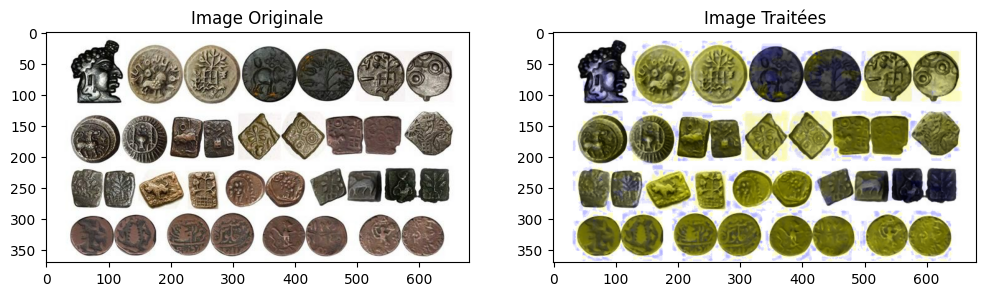

In [61]:
def afficher_images_avant_apres(image_path, luminosite_moyenne, ecart_type, min_val, max_val, saturation_moyenne):
    """Affiche l'image originale et l'image traitée côte à côte pour comparaison."""
    # Charger l'image originale
    image_originale = Image.open(image_path)
    
    # Traiter l'image selon les besoins en prétraitement
    image_traitee = traiter_image(image_path, luminosite_moyenne, ecart_type, min_val, max_val, saturation_moyenne)
    
    # Créer une figure pour afficher les deux images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    

    axes[0].imshow(image_originale)
    axes[0].set_title("Image Originale")
    axes[0].axis('on') 
    

    axes[1].imshow(image_traitee)
    axes[1].set_title("Image Traitées")
    axes[1].axis('on') 
    
    plt.show()

image_path = '/Users/chawkibhd/Desktop/dataset/1/coins_images/coins_images/all_coins/1a203989bd.jpg'
#luminosite_moyenne = 120 
#ecart_type = 60 
#min_val = 50  
#max_val = 200  
#saturation_moyenne = 100 

afficher_images_avant_apres(image_path, luminosite_moyenne, ecart_type, min_val, max_val, saturation_moyenne)

In [69]:
def otsu_threshold(image_array):
    """Applique la méthode d'Otsu pour trouver un seuil optimal."""
    hist, bin_edges = np.histogram(image_array, bins=256, range=(0, 255))
    
    plt.figure(figsize=(10, 5))
    plt.plot(bin_edges[0:-1], hist)  
    plt.title("Histogramme de l'image")
    plt.xlabel("Intensité des pixels")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.show()
    
    prob = hist / np.sum(hist)
    
    max_variance = 0
    optimal_threshold = 0
    
    for t in range(256):
        w0 = np.sum(prob[:t])
        w1 = np.sum(prob[t:])
        
        if w0 == 0 or w1 == 0:
            continue
        mu0 = np.sum(np.arange(0, t) * prob[:t]) / w0
        mu1 = np.sum(np.arange(t, 256) * prob[t:]) / w1
        
        variance = w0 * w1 * (mu0 - mu1) ** 2
        
        # Trouver le seuil qui maximise la variance inter-classes
        if variance > max_variance:
            max_variance = variance
            optimal_threshold = t
    
    return optimal_threshold

In [72]:
def test_image(image_path):
    # Appliquer les traitements nécessaires
    processed_image = traiter_image(image_path, luminosite_moyenne, ecart_type, min_val, max_val, saturation_moyenne)
    
    # Convertir l'image en niveaux de gris pour appliquer Otsu
    processed_image = processed_image.convert('L')
    processed_image_array = np.array(processed_image)

    # Trouver le seuil optimal avec Otsu
    optimal_threshold = otsu_threshold(processed_image_array)
    print(f"Seuil optimal trouvé par la méthode d'Otsu : {optimal_threshold}")

    # Appliquer le seuillage binaire avec le seuil optimal
    binary_image_array = (processed_image_array > optimal_threshold) * 255

    # Convertir le tableau binaire en image
    binary_image = Image.fromarray(np.uint8(binary_image_array))

    # Afficher l'image originale et l'image binaire
    plt.subplot(1, 2, 1)
    plt.title('Image originale')
    plt.imshow(processed_image_array, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('Image binaire avec seuil optimal')
    plt.imshow(binary_image_array, cmap='gray')

    plt.show()

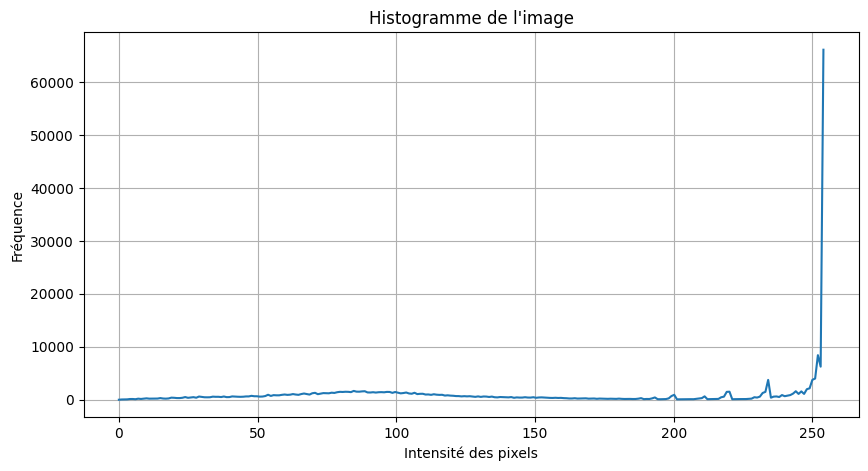

Seuil optimal trouvé par la méthode d'Otsu : 167


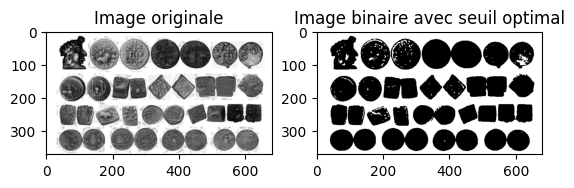

In [73]:
test_image('/Users/chawkibhd/Desktop/dataset/1/coins_images/coins_images/all_coins/1a203989bd.jpg')